In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as py
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import files
uploaded=files.upload()

Saving sales_data.csv to sales_data.csv


In [5]:
data=pd.read_csv("sales_data.csv")
print("Dataset Loaded Successfully")

Dataset Loaded Successfully


In [6]:
print(data.head())

         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001  Electronics  North              195   
1  2022-01-01     S001      P0002     Clothing  North              117   
2  2022-01-01     S001      P0003     Clothing  North              247   
3  2022-01-01     S001      P0004  Electronics  North              139   
4  2022-01-01     S001      P0005    Groceries  North              152   

   Units Sold  Units Ordered  Price  Discount Weather Condition  Promotion  \
0         102            252  72.72         5             Snowy          0   
1         117            249  80.16        15             Snowy          1   
2         114            612  62.94        10             Snowy          1   
3          45            102  87.63        10             Snowy          0   
4          65            271  54.41         0             Snowy          0   

   Competitor Pricing Seasonality  Epidemic  Demand  
0               85.73      Winte

In [7]:
#Data Preprocessing
data["Date"]=pd.to_datetime(data["Date"])
data = data.sort_values(by=["Product ID", "Date"])

In [8]:
#Extract week number&year
data["Year"]=data["Date"].dt.year
data["Week"]=data["Date"].dt.isocalendar().week

In [9]:
#Aggregate historical inventory sales data by product and week
weekly_data = (
    data
    .groupby(['Product ID', pd.Grouper(key='Date', freq='W')])['Demand']
    .sum()
    .reset_index()
)
print("\nWeekly Aggregated Data:")
print(weekly_data.head())


Weekly Aggregated Data:
  Product ID       Date  Demand
0      P0001 2022-01-02    1057
1      P0001 2022-01-09    4476
2      P0001 2022-01-16    4143
3      P0001 2022-01-23    3818
4      P0001 2022-01-30    3952


In [10]:
#Exploring trends and seasonality
print("\nSummary Statistics:")
print(weekly_data["Demand"].describe())


Summary Statistics:
count    2200.000000
mean     3603.683636
std       825.924964
min       712.000000
25%      3188.750000
50%      3730.500000
75%      4134.250000
max      6069.000000
Name: Demand, dtype: float64


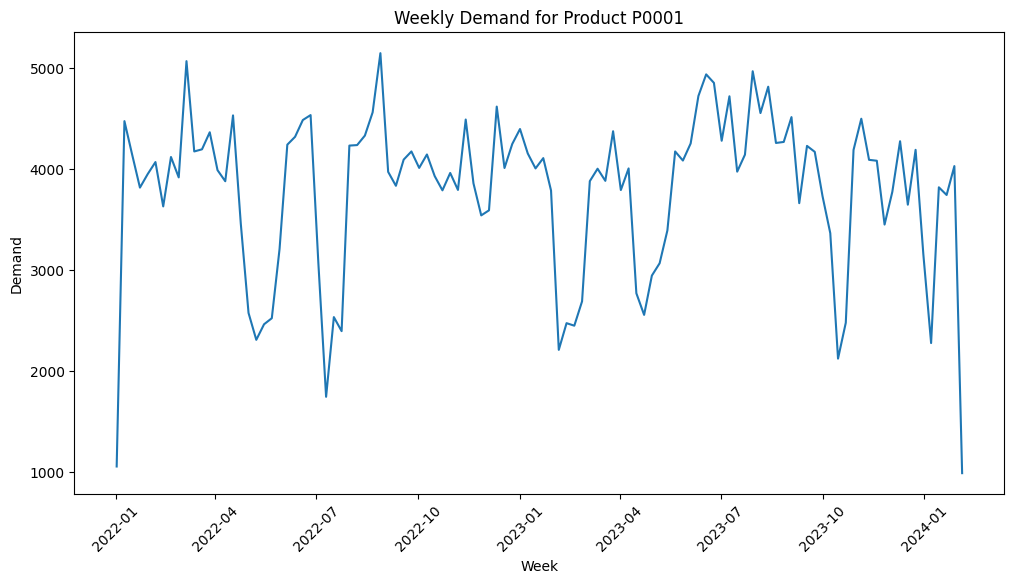

In [47]:
#Plotting weekly demand trend(EDA)
product_id=weekly_data["Product ID"].iloc[0]
product_data=weekly_data[weekly_data["Product ID"]==product_id].copy()
py.figure(figsize=(12,6))
py.plot(product_data["Date"],product_data["Demand"])
py.title(f"Weekly Demand for Product {product_id}")
py.xlabel("Week")
py.ylabel("Demand")
py.xticks(rotation=45)
py.show()

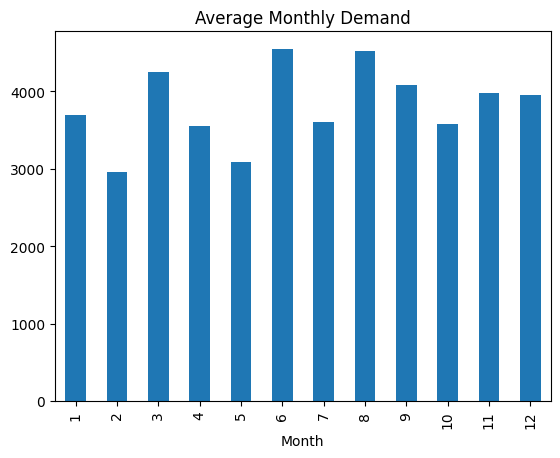

In [48]:
#Seasonality Visualization
product_data["Month"] = product_data["Date"].dt.month
product_data.groupby("Month")["Demand"].mean().plot(kind="bar")
py.title("Average Monthly Demand")
py.show()

In [49]:
#Building Linear Regression Model
product_data=product_data.sort_values("Date").reset_index(drop=True)
product_data["Time_Index"]=np.arange(len(product_data))

# Ensure 'Month' is present
if 'Month' not in product_data.columns:
    product_data["Month"] = product_data["Date"].dt.month

# Create Lag_1 feature for previous week's demand
product_data["Lag_1"] = product_data.groupby("Product ID")["Demand"].shift(1)

# Drop rows with NaN values resulting from shift (first row for each product will have NaN for Lag_1)
product_data.dropna(inplace=True)

X=product_data[["Time_Index", "Month", "Lag_1"]]
Y=product_data["Demand"]

In [50]:
#Removing outliers
# Remove extreme outliers using IQR
Q1 = product_data["Demand"].quantile(0.25)
Q3 = product_data["Demand"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

product_data = product_data[
    (product_data["Demand"] >= lower_bound) &
    (product_data["Demand"] <= upper_bound)
]
X = product_data[["Time_Index", "Month", "Lag_1"]]
Y = product_data["Demand"]

In [51]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3, shuffle=False)

In [52]:
model=LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

In [53]:
Y_pred=model.predict(X_test)

In [54]:
print(product_data['Demand'].mean())

4055.9574468085107


In [55]:
#Evaluating Model Performance
mae=mean_absolute_error(Y_test,Y_pred)
rmse=np.sqrt(mean_squared_error(Y_test,Y_pred))

In [56]:
print("\nModel Performance:")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Model Performance:
Mean Absolute Error: 404.90152939014695
Root Mean Squared Error: 475.84486972953005


In [57]:
#Forecasting next 4 weeks
future_weeks=4
last_time_index=product_data["Time_Index"].iloc[-1]
last_date = product_data["Date"].iloc[-1]
last_actual_demand = product_data["Demand"].iloc[-1] # Get the last actual demand

# Generate future Time_Index and Months
future_time_indices = np.arange(last_time_index + 1, last_time_index + 1 + future_weeks)
future_dates = [last_date + pd.DateOffset(weeks=i) for i in range(1, future_weeks + 1)]
future_months = [date.month for date in future_dates]

# Initialize list to store predictions and lagged demands for iteration
forecasted_demands = []
current_lag_1 = last_actual_demand

for i in range(future_weeks):
    # Prepare features for the current future week
    current_time_index = future_time_indices[i]
    current_month = future_months[i]

    # Create a DataFrame for prediction for the current week
    current_future_X = pd.DataFrame({
        'Time_Index': [current_time_index],
        'Month': [current_month],
        'Lag_1': [current_lag_1]
    })

    # Predict demand for the current week
    predicted_demand = model.predict(current_future_X)[0]
    forecasted_demands.append(predicted_demand)

    # Update Lag_1 for the next iteration with the current prediction
    current_lag_1 = predicted_demand

forecast_df=pd.DataFrame({
    "Future_Week":range(1, future_weeks+1),
    "Forecast_Demand":forecasted_demands
})
forecast_df.to_csv("weekly_demand_forecast.csv",index=False)
print("\nForecast for Next 4 Weeks:")
print(forecast_df)


Forecast for Next 4 Weeks:
   Future_Week  Forecast_Demand
0            1      3742.010344
1            2      3683.378389
2            3      3668.448267
3            4      3661.808948


In [58]:
print(product_data.tail())


    Product ID       Date  Demand  Month  Time_Index   Lag_1
103      P0001 2023-12-24    4192     12         103  3649.0
104      P0001 2023-12-31    3157     12         104  4192.0
106      P0001 2024-01-14    3821      1         106  2279.0
107      P0001 2024-01-21    3745      1         107  3821.0
108      P0001 2024-01-28    4031      1         108  3745.0


In [59]:
from google.colab import files
files.download("weekly_demand_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>